In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale, OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_blobs, make_classification

import tensorflow as tf

import edward as ed
from edward.models import Bernoulli, Normal, Categorical, Multinomial
from edward.util import rbf, Progbar

tf.logging.set_verbosity(tf.logging.INFO)

ed.set_seed(42)

/Users/mmt/anaconda/envs/mnist-uncertainty/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/mmt/anaconda/envs/mnist-uncertainty/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Xdata, Ydata = make_moons(noise=0.2, random_state=0, n_samples=1000)
# Xdata = scale(Xdata)
# X_train, X_test, Y_train, Y_test = train_test_split(Xdata, Ydata, test_size=.5)

In [3]:
# fig, ax = plt.subplots()
# ax.scatter(Xdata[Ydata==0, 0], Xdata[Ydata==0, 1], label='Class 0')
# ax.scatter(Xdata[Ydata==1, 0], Xdata[Ydata==1, 1], color='r', label='Class 1')
# sns.despine(); ax.legend()
# ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [4]:
N_CLASSES = 3

# Xdata, Ydata = make_blobs(centers=N_CLASSES, cluster_std=[.2, .4, 1.2], random_state=0, n_samples=1500)
# Xdata, Ydata = make_classification(
#     n_samples=1500,
#     n_features=2, 
#     n_redundant=0, 
#     n_informative=2,
#     n_classes=3,
#     n_clusters_per_class=1
# )

Xdata1, Ydata1 = make_moons(noise=0.2, random_state=0, n_samples=750)
Xdata2, Ydata2 = make_moons(noise=0.2, random_state=0, n_samples=750)

Xdata2 += [3, .5]
Ydata2 += 1

Xdata = np.vstack((Xdata1, Xdata2))
Ydata = np.hstack((Ydata1, Ydata2))

Xdata = scale(Xdata)

ohc = OneHotEncoder(sparse=False)
Ydata_ohe = ohc.fit_transform(np.atleast_2d(Ydata).T)

X_train, X_test, Y_train, Y_test = train_test_split(Xdata, Ydata_ohe, test_size=.5)

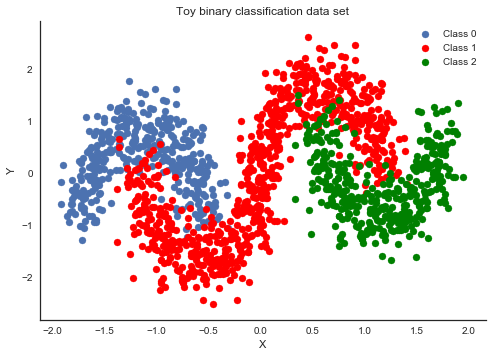

In [5]:
fig, ax = plt.subplots()
ax.scatter(Xdata[Ydata==0, 0], Xdata[Ydata==0, 1], label='Class 0')
ax.scatter(Xdata[Ydata==1, 0], Xdata[Ydata==1, 1], color='r', label='Class 1')
ax.scatter(Xdata[Ydata==2, 0], Xdata[Ydata==2, 1], color='g', label='Class 2')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [6]:
Y_train[:10]

array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [7]:
N, D = X_train.shape

print(N, D)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

750 2
(750, 2) (750, 3)
(750, 2) (750, 3)


In [8]:
C = N_CLASSES
H = 50

X    = tf.placeholder(tf.float32, [None, D], name='X')
y_ph = tf.placeholder(tf.float32, [None, C], name='y_ph')

def neural_network(x, W_0, W_1, W_2, W_3, b_0, b_1, b_2, b_3):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.tanh(tf.matmul(h, W_2) + b_2)
    h = tf.add(tf.matmul(h, W_3), b_3, name='nn')
    return h
#     return tf.reshape(h, [-1])

# MODEL
W_0 = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
W_1 = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
W_2 = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
W_3 = Normal(loc=tf.zeros([H, C]), scale=tf.ones([H, C]))

b_0 = Normal(loc=tf.zeros(H), scale=tf.ones(H))
b_1 = Normal(loc=tf.zeros(H), scale=tf.ones(H))
b_2 = Normal(loc=tf.zeros(H), scale=tf.ones(H))
b_3 = Normal(loc=tf.zeros(C), scale=tf.ones(C))

nn = neural_network(X, W_0, W_1, W_2, W_3, b_0, b_1, b_2, b_3)

y  = Multinomial(total_count=float(1), logits=nn, name='y')

In [9]:
qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, H])),
              scale=tf.Variable(tf.random_normal([D, H])))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([H, H])),
              scale=tf.Variable(tf.random_normal([H, H])))
qW_2 = Normal(loc=tf.Variable(tf.random_normal([H, H])),
              scale=tf.Variable(tf.random_normal([H, H])))
qW_3 = Normal(loc=tf.Variable(tf.random_normal([H, C])),
              scale=tf.Variable(tf.random_normal([H, C])))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([H])),
              scale=tf.Variable(tf.random_normal([H])))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([H])),
              scale=tf.Variable(tf.random_normal([H])))
qb_2 = Normal(loc=tf.Variable(tf.random_normal([H])),
              scale=tf.Variable(tf.random_normal([H])))
qb_3 = Normal(loc=tf.Variable(tf.random_normal([C])),
              scale=tf.Variable(tf.random_normal([C])))

In [10]:
# sess = ed.get_session()
# tf.global_variables_initializer().run()

In [11]:
# Sample functions from variational model to visualize fits.
# rs = np.random.RandomState(0)
# mus = tf.stack(
#     [neural_network(
#         X_test.astype('float32'), 
#         qW_0.sample(), 
#         qW_1.sample(),
#         qW_2.sample(),        
#         qb_0.sample(), 
#         qb_1.sample(),
#         qb_2.sample(),
#     )
#     for _ in range(10)])

In [12]:
# outputs = mus.eval()
# pred = outputs.mean(axis=0) > 0.5

# fig, ax = plt.subplots()
# ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
# ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
# sns.despine()
# ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [13]:
# inference = ed.KLqp({
#         W_0: qW_0, b_0: qb_0,
#         W_1: qW_1, b_1: qb_1,
#         W_2: qW_2, b_2: qb_2
#     }, 
#     data={
#         X: X_train,
#         y: Y_train
#     }
# )

In [14]:
# %pdb

In [15]:
n_iter = 2000
n_samp = 1

inference = ed.KLqp({
        W_0: qW_0, b_0: qb_0,
        W_1: qW_1, b_1: qb_1,
        W_2: qW_2, b_2: qb_2,
        W_3: qW_3, b_3: qb_3,
    }, 
    data={
        X: X_train,
        y: Y_train
    }
)

inference.run(n_iter=n_iter, n_samples=n_samp)

2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 1025.778


In [16]:
# n_iter = 2000
# n_samp = 1

# inference = ed.KLqp({
#         W_0: qW_0, b_0: qb_0,
#         W_1: qW_1, b_1: qb_1,
#         W_2: qW_2, b_2: qb_2
#     }, 
#     data={
#         X: X_train,
#         y: Y_train
#     }
# )

# inference.initialize(n_iter=n_iter, n_samples=n_samp)
# tf.global_variables_initializer().run()

# losses = []
# for t in range(inference.n_iter):
#     info_dict = inference.update()
#     inference.print_progress(info_dict)
#     losses.append(info_dict['loss'])

# inference.finalize()

In [17]:
# plt.plot(losses)

In [18]:
n_samp = 1

n_epoch = 500
batch_size = 50
n_iter_per_epoch = N // batch_size

inference = ed.KLqp({
        W_0: qW_0, b_0: qb_0,
        W_1: qW_1, b_1: qb_1,
        W_2: qW_2, b_2: qb_2,
        W_3: qW_3, b_3: qb_3,
    },
    data={
        y: y_ph
    }
)

inference.initialize(
    n_samples=n_samp, 
    scale={
        X: N / batch_size,
        y: N / batch_size
    }
)
tf.global_variables_initializer().run()

losses = []
pbar = Progbar(n_epoch)
for epoch in range(n_epoch):
    loss = 0.0

    for t in range(n_iter_per_epoch):

        xt   = X_train[t*batch_size:(t+1)*batch_size, :]
        yt   = Y_train[t*batch_size:(t+1)*batch_size, :]

        info_dict = inference.update(feed_dict={
            X: xt,
            y_ph: yt
        })
        loss += info_dict['loss']

    pbar.update(epoch+1, values={'loss': loss / float(n_iter_per_epoch)})
    losses.append(loss / float(n_iter_per_epoch))
    # Print a lower bound to the average marginal likelihood for a sample
#     print("loss {:0.3f}".format(loss))

inference.finalize()

500/500 [100%] ██████████████████████████████ Elapsed: 43s | loss: 909.763


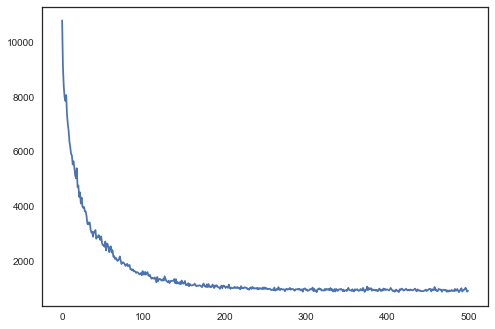

In [19]:
plt.plot(losses)

In [20]:
# outputs = mus.eval()
# pred = outputs.mean(axis=0) > 0.5
# uncer = outputs.std(axis=0)

# # pred = outputs[2,:] > 0.5

# # fig, ax = plt.subplots()
# # ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
# # ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
# # sns.despine()
# # ax.set(title='Actual labels in testing set', xlabel='X', ylabel='Y');

# fig, ax = plt.subplots()
# ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
# ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
# sns.despine()
# ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [21]:
# grid = np.mgrid[-3:3:100j,-3:3:100j]
# grid_2d = grid.reshape(2, -1).T
# Xx, Yy = grid

# back_mus = tf.stack(
#     [neural_network(
#         grid_2d.astype('float32'), 
#         qW_0.sample(), 
#         qW_1.sample(),
#         qW_2.sample(),        
#         qb_0.sample(), 
#         qb_1.sample(),
#         qb_2.sample(),
#     )
#     for _ in range(100)])

# outputs = mus.eval()
# pred = outputs.mean(axis=0) > 0.5

# back_outputs = back_mus.eval()

In [22]:
# cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
# fig, ax = plt.subplots(figsize=(16, 8))
# contour = ax.contourf(Xx, Yy, back_outputs.mean(axis=0).reshape(100, 100), cmap=cmap)
# ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
# ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
# cbar = plt.colorbar(contour, ax=ax)
# _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
# cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [23]:
# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
# fig, ax = plt.subplots(figsize=(16, 8))
# contour = ax.contourf(Xx, Yy, back_outputs.std(axis=0).reshape(100, 100), cmap=cmap)
# ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
# ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
# cbar = plt.colorbar(contour, ax=ax)
# _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
# cbar.ax.set_ylabel('Posterior predictive standard deviation probability of class label = 0');

In [24]:
# X

In [25]:
x_post = ed.copy(X, {
    W_0: qW_0, b_0: qb_0,
    W_1: qW_1, b_1: qb_1,
    W_2: qW_2, b_2: qb_2,
    W_3: qW_3, b_3: qb_3,
})

y_post = ed.copy(y, {
    W_0: qW_0, b_0: qb_0,
    W_1: qW_1, b_1: qb_1,
    W_2: qW_2, b_2: qb_2,
    W_3: qW_3, b_3: qb_3,
})

In [26]:
print("Accuracy error on test data:")
print(ed.evaluate('categorical_accuracy', data={X: X_test, y_post: Y_test}))

Accuracy error on test data:
0.874667


In [27]:
print(y_post.sample().eval({X: X_test})[:10,...])
print(Y_test[:10])

[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]
[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]


In [28]:
def reduce_mean(data, lvars):
#     print(data[X])
#     print(data[y])
#     print(data[x_post])
#     print(data[y_post])
#     print(data.keys())
#     print(lvars.keys())
#     print(data[y_post])
#     print(data[y_post].shape)
    return tf.convert_to_tensor(data[y_post])


a_test, b_test = ed.ppc(
    reduce_mean, 
    data={y_post: Y_test, X: X_test}, 
    latent_vars={
        W_0: qW_0, b_0: qb_0,
        W_1: qW_1, b_1: qb_1,
        W_2: qW_2, b_2: qb_2,
        W_3: qW_3, b_3: qb_3,
    },
    n_samples=100
)

print(a_test.shape, b_test.shape)
# a_test

(100, 750, 3) (100, 750, 3)


([array([ 378.,  104.,   35.,   15.,    9.,   15.,   16.,   30.,  109.,   39.]),
  array([  16.,  222.,   90.,   34.,   27.,   29.,   32.,   73.,  164.,   63.]),
  array([ 402.,   77.,   36.,   26.,   12.,   16.,   14.,   26.,   66.,   75.])],
 array([ 0.        ,  0.096     ,  0.192     ,  0.28799999,  0.38399999,
         0.47999999,  0.57599999,  0.67199998,  0.76799998,  0.86399998,
         0.95999998]),
 <a list of 3 Lists of Patches objects>)

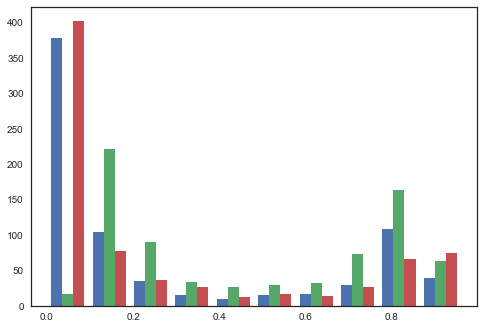

In [29]:
plt.hist(a_test.mean(axis=0))

In [30]:
# a_test.mean(axis=0)

In [31]:
grid = np.mgrid[-3:3:200j,-3:3:200j]
grid_2d = grid.reshape(2, -1).T
Xx, Yy = grid

a_back, b_back = ed.ppc(
    reduce_mean, 
    data={y_post: Y_test, X: grid_2d}, 
    latent_vars={
        W_0: qW_0, b_0: qb_0,
        W_1: qW_1, b_1: qb_1,
        W_2: qW_2, b_2: qb_2,
        W_3: qW_3, b_3: qb_3,
    },
    n_samples=500
)

print(a_back.shape, b_back.shape)
# a_back

(500, 40000, 3) (500, 750, 3)


In [32]:
a_back_cat = np.zeros(a_back.shape[:2])
for i in range(a_back.shape[2]):
    mask = a_back[:,:,i] == 1
    a_back_cat[mask] = i

In [33]:
pred = a_test.mean(axis=0).round()
pred_cat = np.zeros(pred.shape[:1])
for i in range(pred.shape[1]):
    mask = pred[:,i] == 1
    pred_cat[mask] = i

In [34]:
print(Y_test[:10])
print(pred_cat[:10])

[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]
[ 1.  1.  1.  1.  0.  2.  2.  0.  2.  0.]


In [35]:
# plt.imshow(a_back.mean(axis=0).reshape(200, 200, 3))

In [36]:
# img = a_back.mean(axis=0).reshape(200, 200, 3).transpose(1,0,2)
# img = np.dstack((img[:,:,0], img[:,:,2], img[:,:,1]))

# plt.imshow(
#     img
# )

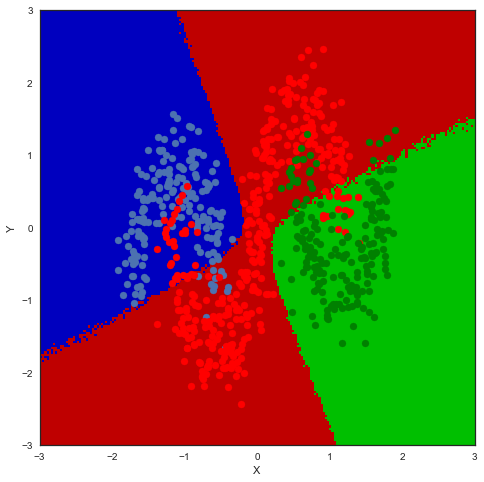

In [39]:
# pred = a_test.mean(axis=0) > 0.5

from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 1), (1, 0, 0), (0, 1, 0)]  # R -> G -> B
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

fig, ax = plt.subplots(figsize=(16, 8))
# contour = ax.contourf(Xx, Yy, a_back_cat.mean(axis=0).reshape(200, 200), cmap=cmap)

img = a_back.mean(axis=0).reshape(200, 200, 3).transpose(1,0,2)
img = np.flipud(np.dstack((img[:,:,1], img[:,:,2], img[:,:,0])))
imga = img.argmax(axis=2)

img2 = np.zeros_like(img)
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        img2[y,x, imga[y,x]] = 1

ax.imshow(
    img2 * .75,
    extent=(-3, 3, -3, 3),
    origin='upper'
)

ax.scatter(X_test[Y_test[:,0]==1, 0], X_test[Y_test[:,0]==1, 1])
ax.scatter(X_test[Y_test[:,1]==1, 0], X_test[Y_test[:,1]==1, 1], color='r')
ax.scatter(X_test[Y_test[:,2]==1, 0], X_test[Y_test[:,2]==1, 1], color='g')
# cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
# cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

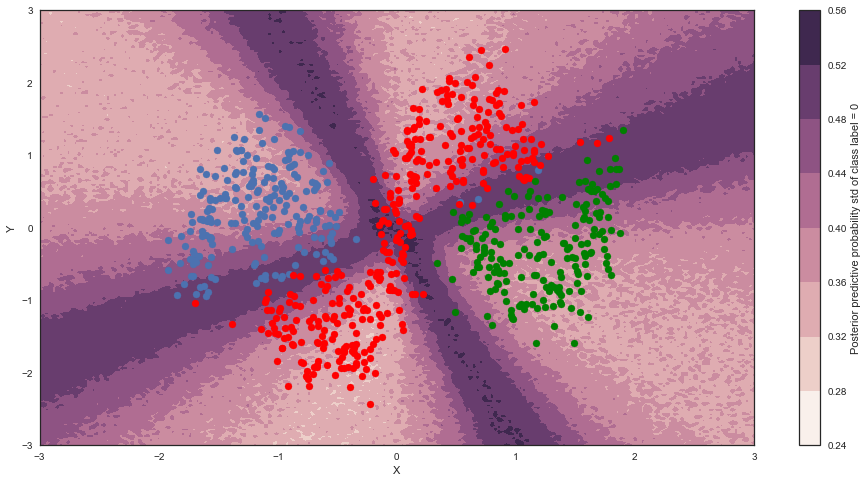

In [40]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 8))
contour = ax.contourf(Xx, Yy, a_back_cat.std(axis=0).reshape(200, 200), cmap=cmap)

ax.scatter(X_test[pred_cat==0, 0], X_test[pred_cat==0, 1])
ax.scatter(X_test[pred_cat==1, 0], X_test[pred_cat==1, 1], color='r')
ax.scatter(X_test[pred_cat==2, 0], X_test[pred_cat==2, 1], color='g')

# ax.scatter(X_test[Y_test[:,0]==1, 0], X_test[Y_test[:,0]==1, 1])
# ax.scatter(X_test[Y_test[:,1]==1, 0], X_test[Y_test[:,1]==1, 1], color='r')
# ax.scatter(X_test[Y_test[:,2]==1, 0], X_test[Y_test[:,2]==1, 1], color='g')

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive probability std of class label = 0');